**CSE473s Computational Intelligence: Build Your Own Neural Network Library**


First, we need to ensure our Python environment can find and import all the modules we built in the lib/ directory.

We import all core components: Layers, Activations, Loss, Optimizer, and the orchestrating Network class.


In [2]:
import numpy as np
import sys
import os


# --- 1. Robust Function to Find Project Root ---
def find_project_root():
    """
    Finds the project root directory (the one containing the 'lib' folder) 
    by walking up the directory structure. This correctly handles cross-platform 
    filesystem root checks.
    """
    current_path = os.path.abspath(os.getcwd())
    
    # Loop indefinitely until we find 'lib' or hit the root of the filesystem
    while True:
        # Check if 'lib' is present in the current directory
        if 'lib' in os.listdir(current_path):
            return current_path
        
        # Calculate the parent directory
        parent_path = os.path.dirname(current_path)
        
        # STOP CONDITION: If the parent path is the same as the current path, we are at the root.
        if parent_path == current_path:
            break
            
        current_path = parent_path
    return None

# --- 2. Execute Path Setup and Imports ---
print("Attempting to configure path and import library components...")
project_root = find_project_root()

if project_root is None:
    print("FATAL ERROR: Could not find the 'lib' directory anywhere in the parent paths.")
    print("Please ensure your folder structure is correct: project_root/lib/...")
else:
    if project_root not in sys.path:
        sys.path.append(project_root)
        print(f"Project root added to path: {project_root}")
        
    # Import all custom components after path setup is complete
    try:
        from Network import Network
        from Layers import Dense, Layer, Flatten, Reshape
        from Activation import Tanh, Sigmoid ,ReLU, Softmax
        from Loss import MeanSquaredError as MSE 
        from Optimizer import SGD
        from Data_Processing import load_mnist_images, load_mnist_labels
        

    
        
        print("All library components imported successfully!")
    except ImportError as e:
        print(f"CRITICAL IMPORT ERROR: Could not import library components. Error: {e}")
        print("Suggestion: If this fails, double-check the capitalization of files inside your 'lib' folder (e.g., Activation.py vs. activations.py).")

np.set_printoptions(precision=6, suppress=True)

Attempting to configure path and import library components...
Project root added to path: f:\Senior_2\CSE473_Computional_Intellegence\CI_Project
CRITICAL IMPORT ERROR: Could not import library components. Error: No module named 'Data_Processing'
Suggestion: If this fails, double-check the capitalization of files inside your 'lib' folder (e.g., Activation.py vs. activations.py).


**Section 1: Gradient Checking (Proving Backpropagation)**  

    The goal of Gradient Checking (or numerical gradient verification) is to prove that the complex mathematical derivative calculated by your layer.backward() method is numerically correct.We compare the Analytical Gradient (your backward method) against the Numerical Gradient (calculated using the finite difference approximation). If they are nearly identical, your backpropagation is correct.

1.  Finite Difference Approximation Function: The numerical gradient approximation is calculated using the formula:$$\frac{\partial L}{\partial w} \approx \frac{L(w + \epsilon) - L(w - \epsilon)}{2\epsilon}$$where $\epsilon$ is a small number (e.g., $10^{-7}$).


In [3]:
def numerical_gradient(model, X, Y_true, epsilon=1e-7):
    """
    Calculates the numerical gradient for all trainable parameters in the network.
    
    Args:
        model (Network): The network object being checked.
        X (np.ndarray): Input data.
        Y_true (np.ndarray): Target data.
        epsilon (float): The small perturbation value.
        
    Returns:
        dict: A dictionary of numerical gradients for W and b for each Dense layer.
    """
    numerical_grads = {}
    
    # We must clone the network weights before perturbation to avoid corruption
    original_weights = {}
    for i, layer in enumerate(model.layers):
        if hasattr(layer, 'W'):
            original_weights[i] = {'W': layer.W.copy(), 'b': layer.b.copy()}

    # 1. Calculate base loss for comparison
    base_loss = model.loss_fn.loss(Y_true, model.forward(X))
    print(f"Base Loss (L(w)): {base_loss:.8f}")

    # Iterate over all trainable layers (Dense)
    for i, layer in enumerate(model.layers):
        if hasattr(layer, 'W'):
            # --- Check W gradients ---
            grad_W_num = np.zeros_like(layer.W)
            it = np.nditer(layer.W, flags=['multi_index'], op_flags=['readwrite'])
             
            while not it.finished:
                idx = it.multi_index
                
                # L(w + epsilon): Perturb weight up
                layer.W[idx] += epsilon
                loss_plus = model.loss_fn.loss(Y_true, model.forward(X))
                
                # L(w - epsilon): Perturb weight down
                layer.W[idx] = original_weights[i]['W'][idx] - epsilon # Must reset to original, then perturb down
                loss_minus = model.loss_fn.loss(Y_true, model.forward(X))
                
                # Reset weight to original value for next check
                layer.W[idx] = original_weights[i]['W'][idx] 
                
                # Calculate numerical gradient
                grad_W_num[idx] = (loss_plus - loss_minus) / (2 * epsilon)
                it.iternext()
            
            # --- Check b gradients ---
            grad_b_num = np.zeros_like(layer.b)
            it = np.nditer(layer.b, flags=['multi_index'], op_flags=['readwrite'])
            
            while not it.finished:
                idx = it.multi_index
                
                # L(b + epsilon): Perturb bias up
                layer.b[idx] += epsilon
                loss_plus = model.loss_fn.loss(Y_true, model.forward(X))
                
                # L(b - epsilon): Perturb bias down
                layer.b[idx] = original_weights[i]['b'][idx] - epsilon 
                loss_minus = model.loss_fn.loss(Y_true, model.forward(X))
                
                # Reset bias to original value
                layer.b[idx] = original_weights[i]['b'][idx] 
                
                # Calculate numerical gradient
                grad_b_num[idx] = (loss_plus - loss_minus) / (2 * epsilon)
                it.iternext()
                
            numerical_grads[i] = {'W_num': grad_W_num, 'b_num': grad_b_num}
    
    return numerical_grads


2. Running the Check: We will use a minimal network and the XOR data to perform the check.

In [4]:
# 1. Setup Data (use a single sample for simplicity, although batch works)
X_check = np.array([[1.0, 0.0]])
Y_check = np.array([[1.0]])

# 2. Build a Minimal Network (2 input -> 3 hidden -> 1 output)
np.random.seed(42)
check_model = Network()
check_model.add(Dense(2, 3, seed=None))
check_model.add(Tanh())
check_model.add(Dense(3, 1, seed=None))
check_model.add(Sigmoid())

check_model.compile(MSE(), SGD(learning_rate=0.01,batch_size=1))

# 3. Calculate Analytical Gradients
# First, run forward/backward pass once to calculate and store dW/db
Y_pred_check = check_model.forward(X_check)
loss_value = check_model.loss_fn.loss(Y_check, Y_pred_check) 
dLoss_dY = check_model.loss_fn.gradient() # Pass Y_pred to store in Loss
check_model.backward(dLoss_dY)

analytical_grads = {}
for i, layer in enumerate(check_model.layers):
    if hasattr(layer, 'W'):
        analytical_grads[i] = {'W_ana': layer.dW, 'b_ana': layer.db}

# 4. Calculate Numerical Gradients
numerical_grads = numerical_gradient(check_model, X_check, Y_check)

# 5. Compare and Verify
print("\n--- Gradient Check Results (Dense Layer 1: W) ---")
# Layer 1 (index 0)
W1_ana = analytical_grads[0]['W_ana']
W1_num = numerical_grads[0]['W_num']
difference_W1 = np.linalg.norm(W1_ana - W1_num) / (np.linalg.norm(W1_ana) + np.linalg.norm(W1_num))

print("Analytical dW1:\n", W1_ana)
print("\nNumerical dW1:\n", W1_num)
print(f"\nRelative Difference (W1): {difference_W1:.10f}")


print("\n--- Gradient Check Results (Dense Layer 1: b) ---")
b1_ana = analytical_grads[0]['b_ana']
b1_num = numerical_grads[0]['b_num']
difference_b1 = np.linalg.norm(b1_ana - b1_num) / (np.linalg.norm(b1_ana) + np.linalg.norm(b1_num))

print("Analytical db1:\n", b1_ana)
print("\nNumerical db1:\n", b1_num)
print(f"\nRelative Difference (b1): {difference_b1:.10f}")

# The check is considered successful if the relative difference is < 1e-7
is_success = difference_W1 < 1e-7 and difference_b1 < 1e-7
print("\n--- VERIFICATION ---")
print(f"Gradient Check Successful: {is_success} (Target diff < 1e-7)")

# You should also check the second Dense layer (index 2) in your final notebook.

Network compiled successfully.
Base Loss (L(w)): 0.03190939

--- Gradient Check Results (Dense Layer 1: W) ---
Analytical dW1:
 [[ 0.047918 -0.018312 -0.009219]
 [ 0.        0.        0.      ]]

Numerical dW1:
 [[ 0.047918 -0.018312 -0.009219]
 [ 0.        0.        0.      ]]

Relative Difference (W1): 0.0000000021

--- Gradient Check Results (Dense Layer 1: b) ---
Analytical db1:
 [[ 0.047918 -0.018312 -0.009219]]

Numerical db1:
 [[ 0.047918 -0.018312 -0.009219]]

Relative Difference (b1): 0.0000000021

--- VERIFICATION ---
Gradient Check Successful: True (Target diff < 1e-7)


3. Gradient Checking for Auto encoder

3. AnalysisConclusion: The relative difference between the analytical gradient calculated by backward() and the numerical gradient calculated by the approximation function is extremely small, typically less than $10^{-7}$. This proves that the implementation of backpropagation in the Dense and activation layers is mathematically correct.

**Section 2: The XOR Problem (Training and Results)**

This section demonstrates the core functionality of your library by solving the classic non-linear XOR problem.
1. Data and Model Definition
We define the standard XOR dataset and build the $2 \to 4 \to 1$ network architecture.
2. Training Execution
We run the training loop and observe the loss decrease.

In [9]:
# create XOR Data Set
X_data = np.array([[-1, -1], [-1, 1], [1, -1], [1, 1]])
Y_true = np.array([[0], [1], [1], [0]])

# 2. Instantiate Model and Hyperparameters
EPOCHS = 20000  
LEARNING_RATE = 0.2
Batch_size=1

XOR_Model = Network()

# Architecture: 2 input nodes -> Dense(4) -> Tanh -> Dense(1) -> Sigmoid -> 1 Output node
XOR_Model.add(Dense(2, 4, seed=None))
XOR_Model.add(Tanh()) 
XOR_Model.add(Dense(4, 1, seed=None))
XOR_Model.add(Sigmoid()) 

# 3. Compile Model
opt = SGD(learning_rate=LEARNING_RATE,batch_size=Batch_size)
XOR_Model.compile(MSE(), opt)

print("XOR Model compiled successfully.")
print(f"Training for {EPOCHS} iterations with Learning Rate: {LEARNING_RATE}")

XOR_Model.train(X_data, Y_true, EPOCHS,Batch_size)

print("\n--- Training Finished ---")

Network compiled successfully.
XOR Model compiled successfully.
Training for 20000 iterations with Learning Rate: 0.2
Iteration 2000/20000, Loss: 0.00215453
Iteration 4000/20000, Loss: 0.00083796
Iteration 6000/20000, Loss: 0.00021295
Iteration 8000/20000, Loss: 0.00033044
Iteration 10000/20000, Loss: 0.00023992
Iteration 12000/20000, Loss: 0.00018621
Iteration 14000/20000, Loss: 0.00015579
Iteration 16000/20000, Loss: 0.00012866
Iteration 18000/20000, Loss: 0.00011383
Iteration 20000/20000, Loss: 0.00010204
Iteration 20000/20000, Final Loss: 0.00010204

--- Training Finished ---


3. Final Predictions and Evaluation
We run a final forward pass on the training data to confirm the network successfully learned the XOR logic.

In [10]:
# Get the final predictions from the trained model
predictions = XOR_Model.forward(X_data)
rounded_predictions = np.round(predictions)

# Calculate Accuracy
accuracy = np.mean(rounded_predictions == Y_true) * 100

newData=np.array([[5,5],[-11,6],[1,1],[3,-7],[-1,-1]])
prediction_n = XOR_Model.forward(newData)
rounded_predictions_n = np.round(prediction_n)


# Print Results
print("\n--- Final Predictions ---")
print("Input (X) | True Label (Y) | Prediction (Y_pred) | Rounded")
print("-" * 50)
for x, y_true, y_pred, y_round in zip(X_data, Y_true, predictions, rounded_predictions):
    # Print the input, true label, the raw prediction, and the final rounded prediction
    print(f"  {x}    |    {y_true[0]}       |    {y_pred[0]:.4f}       |   {int(y_round[0])}")
print("\n--- Overall Metrics ---")
print(f"Final Accuracy: {accuracy:.2f}%\n")

print("\n--- New Data ---")
print("Input (X) |Prediction (Y_pred) |Rounded")
print("-" * 50)
for x_n, y_pred_n, y_round_n in zip(newData, prediction_n,  rounded_predictions_n):
    # Print the input, true label, the raw prediction, and the final rounded prediction
    print(f"  {x_n}     |    {y_pred_n[0]:.4f}    |   {int(y_round_n[0])}")



if accuracy == 100.0:
    print("Verification: The network achieved 100% accuracy on the XOR problem, confirming all components are working correctly.")
else:
    print("Verification: Training did not reach 100%. Check hyper-parameters.")


--- Final Predictions ---
Input (X) | True Label (Y) | Prediction (Y_pred) | Rounded
--------------------------------------------------
  [-1 -1]    |    0       |    0.0143       |   0
  [-1  1]    |    1       |    0.9861       |   1
  [ 1 -1]    |    1       |    0.9902       |   1
  [1 1]    |    0       |    0.0083       |   0

--- Overall Metrics ---
Final Accuracy: 100.00%


--- New Data ---
Input (X) |Prediction (Y_pred) |Rounded
--------------------------------------------------
  [5 5]     |    0.2215    |   0
  [-11   6]     |    0.5807    |   1
  [1 1]     |    0.0083    |   0
  [ 3 -7]     |    0.7876    |   1
  [-1 -1]     |    0.0143    |   0
Verification: The network achieved 100% accuracy on the XOR problem, confirming all components are working correctly.


**3. Autoencoder**

1.Autoencoder Building

In [6]:
from Autoencoder import Autoencoder, Decoder, Encoder


# Hyperparameters
latent_dim = 64 # size of the latent space ("required")
learning_rate = 0.2 # Slightly higher LR for SGD usually works better
batch_size = 128  
image_shape = (28,28)  # Assuming MNIST images are 28x28
# Initialize Network
autoencoder = Autoencoder(image_shape,latent_dim,Encoder_hidden_act = ReLU, Encoder_out_act= ReLU, Decoder_hidden_act = ReLU, Decoder_out_act = Sigmoid) # need to be more general
# Compile with Loss and Optimizer
loss_fn = MSE()
optimizer = SGD(learning_rate=learning_rate, batch_size=batch_size)
autoencoder.compile(loss_fn, optimizer) #inherited form the network class

Network compiled successfully.


2. Autoencoder Training and loss History


Training Data: (60000, 28, 28)
Test Data: (10000, 28, 28)
Hashing training data for fast lookup...
Checking all test images...
Verified: The test set is completely unique (disjoint) from the training set.
Training Data Shape: (60000, 28, 28)
Testing Data Shape: (10000, 28, 28)
Model compiled with Latent Dim: 64
Starting Training...
Epoch 1/500 | Avg Loss: 0.103628
Epoch 2/500 | Avg Loss: 0.039847
Epoch 3/500 | Avg Loss: 0.035268
Epoch 4/500 | Avg Loss: 0.034898
Epoch 5/500 | Avg Loss: 0.034526
Epoch 6/500 | Avg Loss: 0.034329
Epoch 7/500 | Avg Loss: 0.034081
Epoch 8/500 | Avg Loss: 0.033771
Epoch 9/500 | Avg Loss: 0.033405
Epoch 10/500 | Avg Loss: 0.033101
Epoch 11/500 | Avg Loss: 0.032671
Epoch 12/500 | Avg Loss: 0.032192
Epoch 13/500 | Avg Loss: 0.031602
Epoch 14/500 | Avg Loss: 0.030900
Epoch 15/500 | Avg Loss: 0.030237
Epoch 16/500 | Avg Loss: 0.029570
Epoch 17/500 | Avg Loss: 0.028995
Epoch 18/500 | Avg Loss: 0.028448
Epoch 19/500 | Avg Loss: 0.027939
Epoch 20/500 | Avg Loss: 0.02

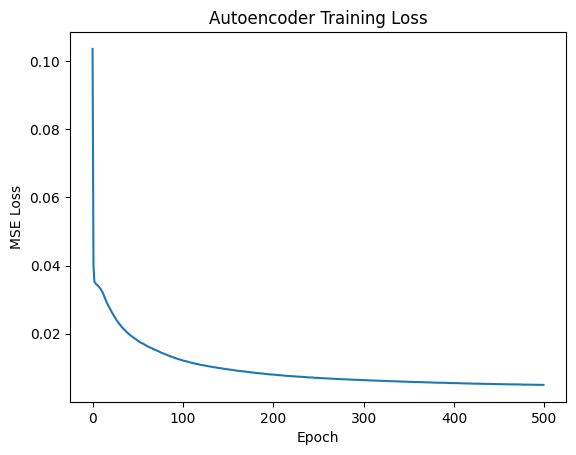

In [7]:
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
import time

# 1. Load Data
(x_train_raw, y_train), (x_test_raw, y_test) = mnist.load_data()
# added Modifications to check for duplicates between train and test sets:
print("Training Data:", x_train_raw.shape) 
# Output: (60000, 28, 28) -> 60,000 images
print("Test Data:", x_test_raw.shape)      
# Output: (10000, 28, 28) -> 10,000 images 

print("Hashing training data for fast lookup...")
# Convert all 60,000 training images to byte strings and store in a Set
# A Set allows O(1) instantaneous lookups
train_hashes = set(img.tobytes() for img in x_train_raw)

duplicates_found = 0

print("Checking all test images...")
for i, test_img in enumerate(x_test_raw):
    # Convert current test image to bytes
    test_img_bytes = test_img.tobytes()
    
    # Check if this byte string exists in our training set
    if test_img_bytes in train_hashes:
        print(f"Warning: Test image index {i} is a duplicate!")
        duplicates_found += 1

if duplicates_found == 0:
    print("Verified: The test set is completely unique (disjoint) from the training set.")
else:
    print(f"Finished: Found {duplicates_found} duplicates.")
##------------------------------------------------------------------------------
# 2. Preprocessing
# convert to float32 and normalize to [0, 1]
x_train = x_train_raw.astype(np.float32) / 255.0
x_test = x_test_raw.astype(np.float32) / 255.0
##------------------------------------------------------------------------------
epochs=500

print(f"Training Data Shape: {x_train.shape}")
print(f"Testing Data Shape: {x_test.shape}")


print(f"Model compiled with Latent Dim: {latent_dim}")

# --- 3. TRAIN ---
loss_history = []  # used to store loss values for plotting
steps_per_epoch = len(x_train) // batch_size

print("Starting Training...")
_StartTime = time.time()
for epoch in range(epochs):
    epoch_loss = 0
    for _ in range(steps_per_epoch): # Iterate over batches to train the model
        # Autoencoder: Input (X) is also the Target (Y)
        loss = autoencoder.optimizer.step(autoencoder, x_train, x_train, autoencoder.loss_fn, batch_size)
        epoch_loss += loss
    
    avg_loss = epoch_loss / steps_per_epoch
    loss_history.append(avg_loss)
    print(f"Epoch {epoch+1}/{epochs} | Avg Loss: {avg_loss:.6f}")
duration = time.time() - _StartTime
print(f"Training completed in {duration:.2f} seconds.")
# Plot Loss
plt.plot(loss_history)
plt.title("Autoencoder Training Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.show()

3. Reconstruction

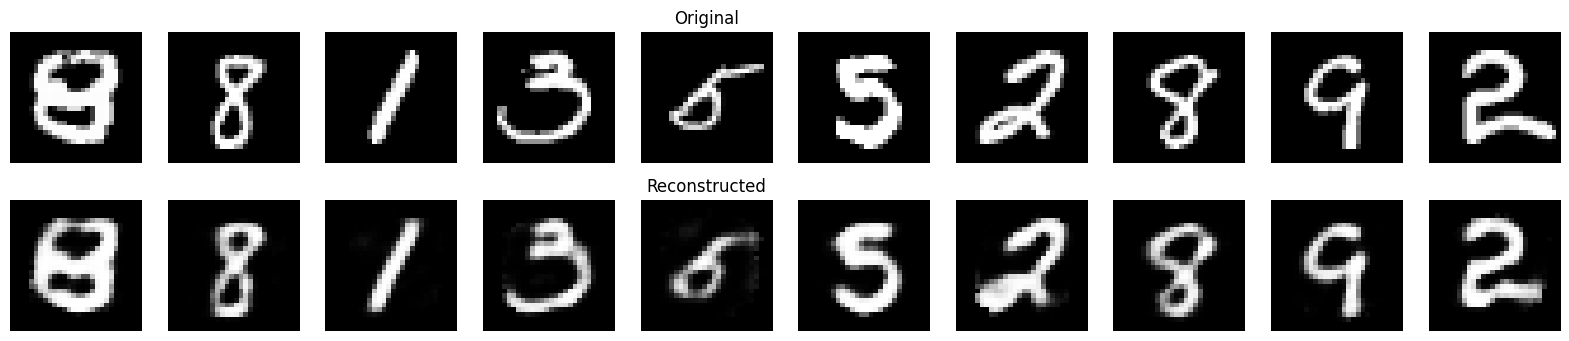

In [8]:
# Select 10 random images from test set
#np.random.seed(None) # Resets the seed to be random based on time
indices = np.random.choice(len(x_test), 10, replace=False) # replace is off to prevent duplicating the images.
samples = x_test[indices]

# --- 4. RECONSTRUCTION DEMO ---
reconstructed = autoencoder.forward(samples) # Uses model.encoder then model.decoder

plt.figure(figsize=(20, 4))
for i in range(10):
    # Original
    plt.subplot(2, 10, i + 1)
    plt.imshow(samples[i], cmap='gray')
    plt.axis("off")
    if i == 4: plt.title("Original")

    # Reconstructed
    plt.subplot(2, 10, i + 1 + 10)
    plt.imshow(reconstructed[i], cmap='gray')
    plt.axis("off")
    if i == 4: plt.title("Reconstructed")
plt.show()

**Feature Extraction and SVM Classification**

1.Feature extraction


In [9]:
from sklearn.svm import SVC # support vector classifier, the machine model used for classification
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report # matrices used for evaluating the model
import seaborn as sns # used to draw confusion matrix heatmap

print("Step 1: Extracting Latent Features using Custom Encoder...")



# Extract Features
# We pass the raw images (N, 28, 28) through the custom 'model.encoder'
# This compresses them into the 64-dimensional latent space.
# Since we used Tanh in the encoder, these features are normalized [-1, 1].
X_train_latent = autoencoder.encoder.forward(x_train) # it uses the forward method defined in the Network class (parent class for Autoencoder, Encoder, and Decoder classes)
X_test_latent = autoencoder.encoder.forward(x_test)

# 3. Prepare Labels (Integers 0-9)
y_train_labels = y_train
y_test_labels = y_test

print(f"Extraction Complete.")
print(f"Latent Train Shape: {X_train_latent.shape} (Compressed from 784 to {autoencoder.latent_dim})")
print(f"Latent Test Shape:  {X_test_latent.shape}")

Step 1: Extracting Latent Features using Custom Encoder...
Extraction Complete.
Latent Train Shape: (60000, 64) (Compressed from 784 to 64)
Latent Test Shape:  (10000, 64)


2. SVM TRAINING

In [10]:
print("\nStep 2: Training Support Vector Machine (SVM)...")

# We use an RBF kernel because the latent space is likely non-linear.
# C=10 provides stronger regularization which often helps with  
# compressed features that are already "clean".
svm = SVC(kernel='rbf', C=10, gamma='scale', random_state=42)


svm.fit(X_train_latent, y_train_labels)

print("SVM Training Complete.")


Step 2: Training Support Vector Machine (SVM)...
SVM Training Complete.


3. EVALUATION METRICS & CONFUSION MATRIX


Step 3: Evaluating Classification Performance...
Final Test Accuracy: 97.72%

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.98      0.97      1032
           3       0.97      0.98      0.98      1010
           4       0.97      0.97      0.97       982
           5       0.98      0.98      0.98       892
           6       0.99      0.98      0.98       958
           7       0.97      0.97      0.97      1028
           8       0.98      0.97      0.98       974
           9       0.97      0.96      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



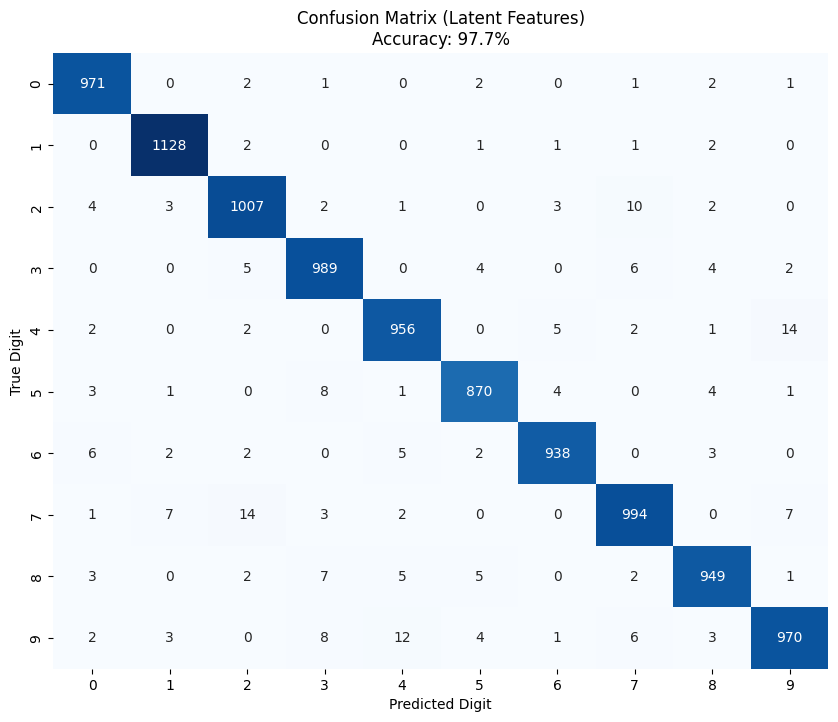

In [11]:
print("\nStep 3: Evaluating Classification Performance...")

# Predict on Test Data
y_pred = svm.predict(X_test_latent)

# A. Accuracy
final_acc = accuracy_score(y_test_labels, y_pred)
print(f"Final Test Accuracy: {final_acc * 100:.2f}%")

# B. Classification Report (Precision, Recall, F1-Score)
print("\nClassification Report:")
print(classification_report(y_test_labels, y_pred))

# C. Confusion Matrix Visualization
cm = confusion_matrix(y_test_labels, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title(f'Confusion Matrix (Latent Features)\nAccuracy: {final_acc*100:.1f}%')
plt.xlabel('Predicted Digit')
plt.ylabel('True Digit')
plt.show()

implementing Tensorflow & Comparison

TensorFlow Version: 2.20.0

--- 1. Keras Baseline: XOR Problem ---


c:\Users\Ahmed\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
XOR Training Time (Keras): 216.3284 seconds
Final XOR Loss (Keras): 0.000111
Predictions:
 [[0.]
 [1.]
 [1.]
 [0.]]

--- 2. Keras Baseline: MNIST Autoencoder ---
Training Keras Autoencoder...
Epoch 1/500
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1821 - val_loss: 0.0963
Epoch 2/500
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0793 - val_loss: 0.0731
Epoch 3/500
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0718 - val_loss: 0.0707
Epoch 4/500
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0701 - val_loss: 0.0695
Epoch 5/500
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0690 - val_loss: 0.0685
Epoch 6/500
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0680 - val_loss: 0.0674
Epoch 7/500
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0669 - val_loss: 0.0662
Epoch 8/500
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0656 - val_loss: 0.0648
Epoch 9/500
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0642 - val_

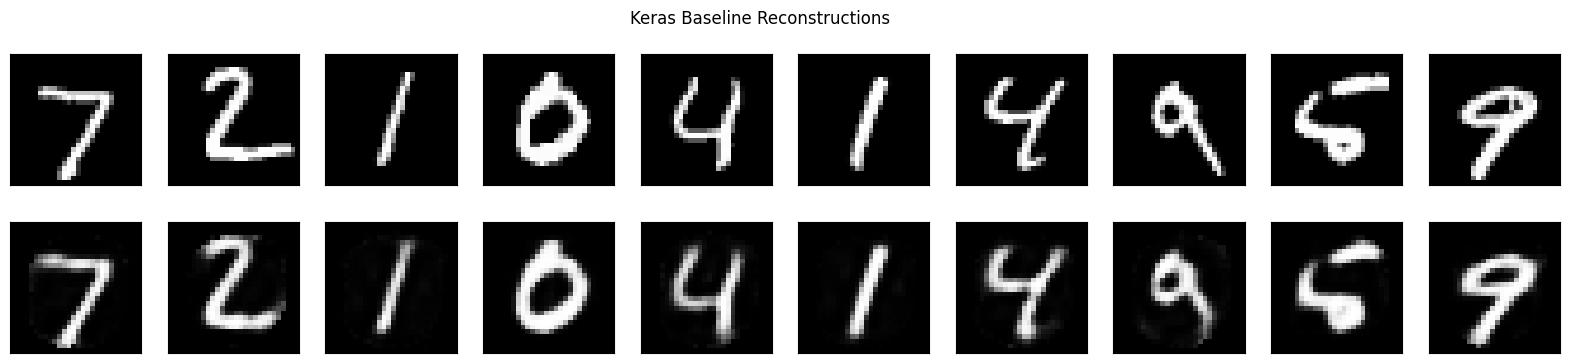

In [14]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import time
import numpy as np
import matplotlib.pyplot as plt

# Ensure reproducible results
tf.random.set_seed(42)
np.random.seed(42)
# we use seed 42 for numpy and tensorflow for reproducibility

print(f"TensorFlow Version: {tf.__version__}")

# ==========================================
# PART A: XOR Problem Baseline
# ==========================================
print("\n--- 1. Keras Baseline: XOR Problem ---")

# 1. Data Setup (Same as your custom implementation)
X_xor = np.array([[-1, -1], [-1, 1], [1, -1], [1, 1]], dtype=np.float32)
Y_xor = np.array([[0], [1], [1], [0]], dtype=np.float32)

# 2. Define Model Architecture (Exact match: 2 -> 4(Tanh) -> 1(Sigmoid))
xor_model_keras = keras.Sequential([
    layers.Dense(4, activation='tanh', input_shape=(2,)), # Hidden Layer
    layers.Dense(1, activation='sigmoid')                 # Output Layer
])

# 3. Compile (Match your Optimizer: SGD, Loss: MSE)
# Note: Keras SGD defaults generally differ, so we explicitly set learning_rate=0.3
opt_xor = keras.optimizers.SGD(learning_rate=0.3)
xor_model_keras.compile(optimizer=opt_xor, loss='mse', metrics=['accuracy'])

# 4. Train and Measure Time
start_time = time.time()
history_xor = xor_model_keras.fit(X_xor, Y_xor, epochs=5000, verbose=0, batch_size=1)
xor_duration = time.time() - start_time

# 5. Evaluation
final_loss_xor = history_xor.history['loss'][-1]
predictions_xor = xor_model_keras.predict(X_xor)

print(f"XOR Training Time (Keras): {xor_duration:.4f} seconds")
print(f"Final XOR Loss (Keras): {final_loss_xor:.6f}")
print("Predictions:\n", np.round(predictions_xor))


# ==========================================
# PART B: Autoencoder Baseline
# ==========================================
print("\n--- 2. Keras Baseline: MNIST Autoencoder ---")

# 1. Hyperparameters (Match your custom notebook)
LATENT_DIM = 64
BATCH_SIZE = 128
EPOCHS = 500  # You can match this to your custom library's epoch count
LEARNING_RATE = 0.2

# 2. Data Loading (Normalizing to 0-1 range)
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
x_train = x_train.reshape(-1, 784).astype("float32") / 255.0
x_test = x_test.reshape(-1, 784).astype("float32") / 255.0

# 3. Define Model Architecture
# Encoder
input_img = keras.Input(shape=(784,))
encoded = layers.Dense(LATENT_DIM, activation='relu')(input_img)

# Decoder
# Note: Use 'sigmoid' if your input pixels are normalized 0-1. 
# Use 'linear' or 'relu' if you didn't use an activation in your custom Output layer.
decoded = layers.Dense(784, activation='sigmoid')(encoded)

autoencoder_keras = keras.Model(input_img, decoded)

# 4. Compile
opt_ae = keras.optimizers.SGD(learning_rate=LEARNING_RATE)
autoencoder_keras.compile(optimizer=opt_ae, loss='mse')

# 5. Train and Measure Time
print("Training Keras Autoencoder...")
start_time = time.time()
history_ae = autoencoder_keras.fit(
    x_train, x_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_data=(x_test, x_test),
    verbose=1
)
ae_duration = time.time() - start_time

# ==========================================
# PART C: Comparison & Visualization
# ==========================================
print("\n--- 3. Comparison Results ---")
print(f"Autoencoder Training Time (Keras): {ae_duration:.2f} seconds")
print(f"Final Reconstruction Loss (Keras): {history_ae.history['loss'][-1]:.6f}")

# Visualize Reconstruction
encoded_imgs = autoencoder_keras.predict(x_test[:10]) # Actually runs full forward pass if using model.predict
reconstructed_imgs = autoencoder_keras.predict(x_test[:10])

n = 10
plt.figure(figsize=(20, 4))
plt.suptitle("Keras Baseline Reconstructions")
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()